# Davis-Panas-Zariphopoulou model

This notebook presents a model for pricing options in a market with proportional transaction costs. The model is taken from the celebrated work of Davis-Panas-Zariphopoulou 1993 [*link-to-the-paper*](https://web.ma.utexas.edu/users/zariphop/pdfs/TZ-7.pdf). 

#### This is a very powerful model!

However, due to its complexity (and time complexity), it is not very well known to the practitioners.

The purpose of this notebook is to explain **in simple terms** the main ideas of the model, and show how to implement it numerically. **The results will surprise you!**

## Contents
   - [Model description](#sec1)
      - [Portfolio dynamics (original)](#sec1.1)
      - [Some definitions](#sec1.2)
   - [Singular control problem](#sec2)
      - [Maximization problem](#sec2.1)
      - [Indifference pricing](#sec2.2)
   - [Variable reduction](#sec3)
      - [Minimization problem](#sec3.1)
      - [Portfolio dynamics (2 state variables)](#sec3.2)
      - [HJB variational inequality](#sec3.3)
      - [Indifference price (explicit form)](#sec3.4)
   - [Numerical Solution](#sec4)
       - [Discrete SDE](#sec4.1)
       - [Algorithm](#sec4.2)
   - [Numerical Computations](#sec5)
       - [Time complexity](#sec5.1)
       - [Is the risk aversion important?](#sec5.2)
       - [Is the drift important?](#sec5.3)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from scipy.stats import norm

%matplotlib inline

<a id='sec1'></a>
# Model Description

<a id='sec1.1'></a>
### Portfolio dynamics (original)
Let us consider a portfolio composed by: 
- A bank account $\mathbf{B}$ paying an interest rate $r > 0$. 
- A stock $\mathbf{S}$. 
- A number of shares $\mathbf{Y}$ of the stock $\mathbf{S}$. 

The 3-D state of the portfolio at time $t\in [t_0,T]$ is $(B_t,Y_t,S_t)$ and evolves following the SDE:

\begin{equation}
 \begin{cases}
 dB_t &=  rB_t dt - (1+\theta_b)S_{t} dL_t + (1-\theta_s) S_{t} dM_t \\
 dY_t &=  dL_t - dM_t \\
 dS_t &=  S_{t} \left( \mu dt + \sigma dW_t \right).
\end{cases}
\end{equation} 

The parameters $\theta_b$, $\theta_s \geq 0$ are the proportional transaction costs when buying and selling respectively. 

The processes  $\{(L_t, M_t)\}_{t \in [t_0,T]}$ are the **trading strategies**, i.e. the **controls** of the problem. 

The process $\{L_t\}_{t}$ represents the cumulative number of shares bought up to time $t$, and $\{M_t\}_{t}$ represents the number of shares sold up to time $t$. 
They are right-continuous, finite variation, non-negative and increasing processes. If the time $t$ is a discontinuous point (there is a transaction), the variation of the processes are indicated as
$$ \Delta L_t= L(t)-L(t^-) \quad \quad \Delta M_t= M(t)-M(t^-) $$

Let us consider an example. If at time $t$, the investor wants to buy $\Delta L_t$ shares. Then the portfolio changes as

$$ \Delta Y_t =  \underbrace{\Delta L_t}_{\text{shares bought}} \quad \quad
 \Delta B_t =  - \underbrace{(1+\theta_b)S_t}_{\text{adjusted price}} \Delta L_t $$

where the **adjusted price** is the real cost of the stock (incorporating the transaction cost).

If there are no transactions, the portfolio has the simple well known evolution:

$$
 \begin{cases}
 dB_t &=  rB_t dt \\
 dY_t &=  0 \\
 dS_t &=  S_{t} \left( \mu dt + \sigma dW_t \right).
\end{cases}
$$


<a id='sec1.2'></a>
### Some definitions

The **cash value** function $c(y,s) : \mathbb{R} \times \mathbb{R}^+ \to \mathbb{R}$, is defined as the value in cash when the shares in the portfolio are liquidated i.e.  
long positions are sold and short positions are covered.

$$
c(y,s) := \begin{cases} 
(1+\theta_b)ys, & \text{if } y\leq 0 \\ 
(1-\theta_s)ys, & \text{if } y>0 . 
\end{cases} 
$$

For $t\in [t_0,T]$, the **total wealth** process in a portfolio with zero options is defined as:

$$ \mathcal{W}^0_t := B_t + c(Y_t,S_t). $$

If the portfolio contains an option with maturity $T$ and strike $K$, then the wealth process becomes:    
**Writer**:
 
$$ \mathcal{W}^{w}_t = \; B_t + c(Y_t,S_t) \mathbb{1}_{\{t < T\}} +
 c(Y_t,S_t) \mathbb{1}_{\{t = T,\, S_t(1+ \theta_b ) \leq K\}} +
 \biggl( c\bigl( Y_t-1,S_t \bigr) + K \biggr) \mathbb{1}_{\{t=T,\, S_t(1+ \theta_b ) > K \}} $$
 
**Buyer**:   

 $$   \mathcal{W}^{b}_t = \; B_t + c(Y_t,S_t) \mathbb{1}_{\{t < T\}} +
  c(Y_t,S_t) \mathbb{1}_{\{t = T,\, S_t(1+ \theta_b ) \leq K\}} +
  \biggl( c\bigl( Y_t+1,S_t \bigr) - K \biggr) \mathbb{1}_{\{t=T,\, S_t(1+ \theta_b ) > K \}}  $$
  
For $t_0 \leq t<T$, the wealths $\mathcal{W}^{w}_t$ and $\mathcal{W}^{b}_t$ are equal to $\mathcal{W}^{0}_t$, but when $t = T$ they differ because of the payoff of the option. The writer gives away a share and recives the strike and the buyer receive a share and pays the strike. 

Note that considering a market with transaction costs, implies a different condition for the exercise of the option. Now the buyer should exercise if $S_t(1+ \theta_b ) > K$, because the true price of the share incorporates the value of the transaction costs. Let's see the plot:

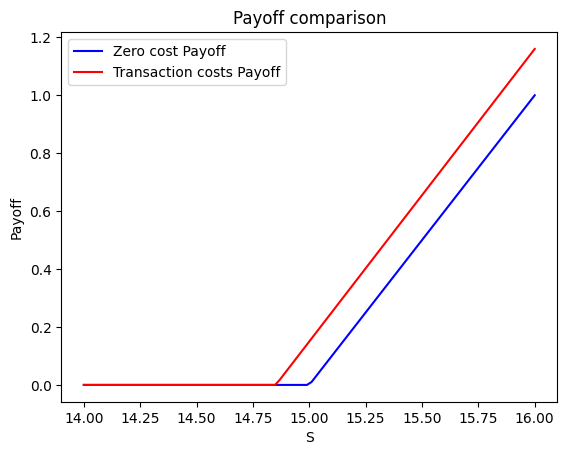

In [3]:
S = np.linspace(14, 16, 100)
K = 15  # strike
cost_b = 0.01  # transaction cost

plt.plot(S, np.maximum(S - K, 0), color="blue", label="Zero cost Payoff")
plt.plot(S, np.maximum(S * (1 + cost_b) - K, 0), color="red", label="Transaction costs Payoff")
plt.xlabel("S")
plt.ylabel("Payoff")
plt.title("Payoff comparison")
plt.legend(loc="upper left")
plt.show()

<a id='sec2'></a>
## Singular control problem

<a id='sec2.1'></a>
### Maximization problem

The **value function** of the maximization problem for $j=0,w,b$ (corresponding to the three portfolios: no option, writer, buyer) is defined as:

\begin{equation}
V^j(t,b,y,s) = \sup_{L,M} \;  \mathbb{E}\biggl[ \; \mathcal{U}( \mathcal{W}^{j}_T ) \; \bigg| \; B_{t} = b, Y_{t} = y, S_{t} = s \biggr],             
\end{equation}

where $\mathcal{U}: \mathbb{R} \to \mathbb{R}$ is a concave increasing **utility function**. The **exponential utility** is what we are looking for:

\begin{equation}
 \mathcal{U}(x) := 1- e^{-\gamma x}   \quad \quad \gamma >0 .
\end{equation}

<a id='sec2.2'></a>
### Indifference pricing

The writer (buyer) option price is defined as the amount of cash to add (subtract) to the bank account, 
such that the maximal expected utility of wealth of the writer (buyer) is the same he could get with 
the zero-option portfolio.

* The **writer price** is the value $p^w>0$ such that 
 \begin{equation}
  V^0(t,b,y,s) = V^w(t,b+p^w,y,s),
 \end{equation}
 
* The **buyer price** is the value $p^b>0$ such that
 \begin{equation}
  V^0(t,b,y,s) = V^b(t,b-p^b,y,s).
 \end{equation}

<a id='sec3'></a>
## Variable reduction

Using the properties of the exponential utility, it is possible to remove $\mathbf{B}$ from the state variables.

$$ V^j(t,b,y,s) = \sup_{L,M} \; \mathbb{E}_{t,b,y,s}\biggl[  1- e^{-\gamma \mathcal{W}^j(T) } \biggr]   
	     = 1- e^{-\gamma \frac{b}{\delta(t,T)}} Q^j(t,y,s), $$
         
where $\delta(t,T) = e^{-r(T-t)}$. (for the full calculations, check the paper. Equations 4.21 -4.25).

<a id='sec3.1'></a>
### Minimization problem

\begin{equation}
Q^j(t,y,s) = \inf_{L,M} \; \mathbb{E}_{t,y,s}\biggl[ \;
	     e^{-\gamma \bigl[ -\int_{t}^T (1+\theta_b) \frac{S_u}{\delta(u,T)} dL_u +
	     \int_{t}^T (1-\theta_s) \frac{S_u}{\delta(u,T)} dM_u \bigr] } \; H^j(Y_T,S_T) \bigg]  
\end{equation}

The exponential term inside the expectation can be considered as a discount factor, and the second term is the terminal payoff:
 - No option:
 
 $$ H^0(y,s) = e^{-\gamma \, c(y,s)}. $$
 
 - Writer:
 
 $$ H^w(y,s) = e^{-\gamma \bigl[ c(y,s)\mathbb{1}_{\{s(1+\theta_b) \leq K\}} + 
 \bigl( c( y-1,s) + K \bigr) \mathbb{1}_{\{s(1+\theta_b)>K\}} \bigr] }.$$
 
 - Buyer:

$$  H^b(y,s) = e^{-\gamma \bigl[ c(y,s)\mathbb{1}_{\{s(1+\theta_b) \leq K\}} + 
 \bigl( c( y+1,s) - K \bigr) \mathbb{1}_{\{s(1+\theta_b)>K\}} \bigr] }.
$$

<a id='sec3.2'></a>
### Portfolio dynamics (2 state variables)

In order to simplify the numerical computations,let us pass to the log-variable $X_t = \log(S_t)$.

The resulting portfolio dynamics is:

\begin{equation}
 \begin{cases}
 dY_t &=  dL_t - dM_t \\
 dX_t &= \biggl( \mu - \frac{1}{2} \sigma^2 \biggr) dt + \sigma dW_t.
\end{cases}
\end{equation} 


<a id='sec3.3'></a>
### HJB variational inequality

The Hamilton Jacobi Bellman equation associated to the minimization problem is:

$$
 \min \; \biggl\{ \; \frac{\partial Q^j}{\partial t} + (\mu-\frac{1}{2}\sigma^2) \frac{\partial Q^j}{\partial x}
+ \frac{1}{2}\sigma^2 \frac{\partial^2 Q^j}{\partial x^2}  ,
 \; \frac{\partial Q^j}{\partial y} +(1+\theta_b) e^x \frac{\gamma}{\delta(t,T)}Q^j \; , 
\; -\biggl( \frac{\partial Q^j}{\partial y}+(1-\theta_s)e^x \frac{\gamma}{\delta(t,T)} Q^j 
\biggr) \biggr\} = 0. 
$$

<a id='sec3.4'></a>
### Indifference price (explicit form)

Using again the explicit form of the utility function, we obtain formulas for the option prices:

$$
 p^w(t_0,y,x) = \frac{\delta(t_0,T)}{\gamma} \log \biggl( \frac{Q^w(t_0,y,e^x)}{Q^0(t_0,y,e^x)} \biggr), $$
 
$$ p^b(t_0,y,x) = \frac{\delta(t_0,T)}{\gamma} \log \biggl( \frac{Q^0(t_0,y,e^x)}{Q^b(t_0,y,e^x)} \biggr).
$$

<a id='sec4'></a>
# Numerical Solution

<a id='sec4.1'></a>
###  Discrete SDE

As usual, we introduced the time step $\Delta t = \frac{T}{N}$, where we assumed $t_0 = 0$ and $N \in \mathbb{N}$. 
The time $t_n = n \Delta t$, for $n \in \{0,1,2, ..., N\}$. 

The space discretization has 2 dimensions:
- The space step $h_x$ is defined as $h_x = \sigma \sqrt{\Delta t}$.
- The space step is $h_y$. In this computations we choose $h_x = h_y$.

The discretized version of the Stochastic Differential equation is: 

$$
 \begin{cases}
 \Delta Y_n &= \; \Delta L_n - \Delta M_n \\
 \Delta X_n &= \; (\mu - \frac{1}{2} \sigma^2 )  \Delta t + \sigma \Delta W_n
\end{cases}
$$

Both $\Delta L_n$ and $\Delta M_n$ at each time $t_n$ can assume values in $\{0,h_y\}$. They cannot be different from zero at the same time (It is quite strange to buy and sell at the same time, right?)

The variable $\Delta W_n$ has $\frac{1}{2}$ probability of being equal to $h_x$ and $\frac{1}{2}$ probability of being equal to $-h_x$.

The variation $\Delta X_n$ is $\pm h_x$ plus the drift component. We obtain a recombining **binomial tree**.

### Binomial tree with drift

In [4]:
N = 6
dt = 1 / N
S0 = 15
x0 = np.log(S0)
mu = 0.1
sig = 0.25
h_x = sig * np.sqrt(dt)

for n in range(N):
    x = np.array([x0 + (mu - 0.5 * sig**2) * dt * n + (2 * i - n) * h_x for i in range(n + 1)])
    print(x)

[2.7080502]
[2.61744646 2.82157061]
[2.52684272 2.73096687 2.93509101]
[2.43623898 2.64036313 2.84448727 3.04861142]
[2.34563524 2.54975939 2.75388353 2.95800768 3.16213182]
[2.2550315  2.45915565 2.6632798  2.86740394 3.07152809 3.27565223]


<a id='sec4.2'></a>
###  Algorithm

Using the Dynamic Programming Principle (DPP) on the minimization problem we obtain a recursive algorithm on the nodes of the grid.

$$ \begin{aligned}
 Q^{j}(t_n,Y_n,X_n) = \min  
 & \; \biggl\{ \mathbb{E}_n \biggl[ Q \bigl( t_{n+1}, Y_n, X_n + \Delta X_n \bigr) \biggr], \\ \nonumber
 & \; \exp \biggl(\frac{\gamma}{\delta(t_n,T)} (1+\theta_b) e^{X_n} \Delta L_n \biggr) 
  \mathbb{E}_n \biggl[ Q^{j} \bigl( t_{n+1}, Y_n+\Delta L_n, X_n + \Delta X_n \bigr) \biggr], \\ \nonumber
 & \; \exp \biggl(\frac{-\gamma}{\delta(t_n,T)} (1-\theta_s) e^{X_n} \Delta M_n \biggr)
  \mathbb{E}_n \biggl[ Q^{j} \bigl( t_{n+1}, Y_n-\Delta M_n, X_n + \Delta X_n \bigr) \biggr]
 \biggr\}.
\end{aligned} $$

#### How to solve this problem?
- Create a **binomial tree** with N time steps. 
- Create a "shares vector" **y** with dimension M. 
- Initialize a two dimensional grid of size $(N+1)\times M$, to be filled with the values of the terminal conditions $H^j(y,e^x)$ for $j=0,w,b$ (see [Minimization problem](#sec3.1))
- Create a backward loop over time and find $Q^j(0,0,X_0)$

#### Computational complexity?  Well... Quite high. 
- A binomial tree with N time steps has $\sum_{n=0}^N (n+1) = \frac{N(N+1)}{2} + (N+1) = (N+1)(\frac{N}{2}+1)$ nodes. 
The loop over all the nodes is $\mathcal{O}(N^2)$.
- If we assume $M \sim N$, the loop over all the values of **y** has another $\mathcal{O}(N)$.
- The minimum search for every point in **y**, produces another $\mathcal{O}(N)$ operations.

Therefore the total computational complexity is of $\mathcal{O}(N^4)$.


#### For space reasons, I will not expose the code here in the notebook. The interested reader can peek the (clear and commented) code inside the class TC_pricer.  [code](./functions/TC_pricer.py)



- Optimal policy when there is no option : we must hold $y = \frac{\delta(T,s)(\alpha-r)}{\gamma S \sigma^2}$
- Optimal policy when there is an option : we must hold $y = \frac{\delta(T,s)(\alpha-r)}{\gamma S \sigma^2} + \Delta_{BS}$

<a id='sec5'></a>
# Numerical computations

Let us import the classes we need:
 - **Option_param**: creates the option object
 - **Diffusion_process**: creates the process object
 - **TC_pricer**: creates the pricer for this model
 - **BS_pricer**: creates the Black-Scholes pricer, useful for making comparisons.  

# Helper functions

In [47]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def run_and_track(pricer, N=500, TYPE="writer"):
    """
    Runs the DP with tracking turned on.
    Returns: price, Q_slices, A_slices, x_grids, y_grid
    """
    price = pricer.price(
        N=N, TYPE=TYPE, track_policy=True, Time=False
    )
    Q_slices      = pricer.Q_slices[TYPE]
    A_slices      = pricer.action_slices[TYPE]

    # rebuild y_grid & central index
    dt    = pricer.T / N
    dx    = pricer.sig * np.sqrt(dt)
    M     = int(0.8 * np.floor(N/2))
    y_grid = np.linspace(-M*dx, M*dx, 2*M+1)

    # build x_grids list
    x0     = np.log(pricer.S0)
    x_grids = []
    for k in range(N+1):
        xk = x0 + (pricer.mu - 0.5*pricer.sig**2)*(dt*k) \
                 + (2*np.arange(k+1)-k)*dx
        x_grids.append(xk)

    return price, Q_slices, A_slices, x_grids, y_grid

def compute_num_shares(A_slices, dy):
    """
    A_slices: list of length N+1, where A_slices[t].shape = (t+1, Ny)
               and entries are {-1,0,+1}.
    dy:        the grid‐spacing in the y‐direction (Δy).
    
    Returns the average traded shares per decision‐point, i.e.
    sum_t,i |Δα_{t,i}| divided by total number of nodes, multiplied by Δy.
    """
    N = len(A_slices) - 1
    total_moved = 0.0
    total_nodes = 0
    for t in range(1, N):
        A = A_slices[t]            # shape (t+1, Ny)
        total_moved += np.abs(A).sum() * dy
        total_nodes += A.size
    return total_moved / total_nodes

def compute_phi_w(xk, K, r, mu, sig, T, t, gamma):
    """
    Given a log-price grid xk and time t, compute:
      S_k = exp(xk)
      d1, Δ_BS
      φ_w = Δ_BS + δ(T,t)*(μ−r)/(γ S σ^2)
    Returns (S_k, delta_bs, phi_w)
    """
    tau = T - t
    S_k = np.exp(xk)
    d1  = (np.log(S_k/K) + (r + 0.5*sig**2)*tau) / (sig * np.sqrt(tau))
    delta_bs = norm.cdf(d1)

    δ = np.exp(-r*tau)
    drift = (mu - r)/(sig**2)
    phi_w = delta_bs + δ * drift/(gamma * S_k)

    return S_k, delta_bs, phi_w

def plot_policy_and_phi(xk, y_grid, A_slice, phi_w, title="Policy"):
    """
    Plots the DP action map (A_slice: shape (len(xk), len(y_grid))) transposed,
    then overlays phi_w vs xk.
    """
    X,Y = np.meshgrid(xk, y_grid, indexing='xy')
    plt.figure(figsize=(6,4))
    cmap = plt.get_cmap('RdYlBu', 3)
    plt.pcolormesh(X, Y, A_slice.T, cmap=cmap, vmin=-1, vmax=1, shading='auto')
    plt.plot(xk, phi_w, 'k--', label=r'$\Delta_{BS}+\frac{\delta(T,s)(\alpha-r)}{\gamma S \sigma^2}$', linewidth=1.5)
    plt.colorbar(ticks=[-1,0,1], label='Action')
    plt.xlabel('log-price $x$')
    plt.ylabel('position $y$')
    plt.ylim((-0.5,1))
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def compute_trade_frequency(A_slices):
    """
    A_slices: list of length N+1, where A_slices[t].shape = (t+1, Ny)
    and entries are {-1,0,+1}.  We skip t=0 and t=N (no decision there).
    Returns: fraction of (t,j,i) states at which you trade (A!=0).
    """
    N = len(A_slices) - 1
    traded = 0
    total  = 0
    for t in range(1, N):
        A = A_slices[t]
        traded += np.count_nonzero(A != 0)
        total  += A.size
    return traded / total

def simulate_wealth_and_policy(TC2, As, xgrids, ygrid, S0, T, mu, sigma, r, cost_b, cost_s, N, B0=0.0, seed=None):
    """
    Simulate one GBM price path and apply the DP‐derived policy As to generate
    a trading strategy (y_t) and cash B_t, yielding total wealth W_t.

    Parameters
    ----------
    TC2 : TC_pricer2 instance (already initialized)
    As : list of action arrays of length N+1, each shape (k+1, Ny)
    xgrids : list of log‐price grids for each k
    ygrid : array of y‐grid positions, length Ny
    S0, T, mu, sigma, r : model parameters
    cost_b, cost_s : transaction cost fractions
    N : number of time steps
    B0 : initial cash (float)
    seed : random seed for reproducibility

    Returns
    -------
    t_vec : (N+1,) array of times
    S_path : (N+1,) simulated price path
    y_path : (N+1,) share holdings
    B_path : (N+1,) cash account
    W_path : (N+1,) total wealth
    """
    dt = T / N
    t_vec = np.linspace(0, T, N+1)
    if seed is not None:
        np.random.seed(seed)
    # Simulate Brownian increments
    dW = np.sqrt(dt) * np.random.randn(N)
    W = np.concatenate([[0], np.cumsum(dW)])
    # Simulate GBM price path
    S_path = S0 * np.exp((mu - 0.5*sigma**2)*t_vec + sigma*W)
    
    # Precompute dy and Ny
    dy = ygrid[1] - ygrid[0]
    Ny = len(ygrid)
    
    # Initialize arrays
    y_path = np.zeros(N+1)
    B_path = np.zeros(N+1)
    B_path[0] = B0
    
    # Iterate
    for k in range(N):
        # 1) accrue interest on cash
        B_path[k] *= np.exp(r * dt)
        
        # 2) find nearest grid indices
        # price: find index in xgrids[k] nearest to log S
        idx_price = np.argmin(np.abs(xgrids[k] - np.log(S_path[k])))
        # shares: find index in ygrid nearest to current y
        idx_y = np.argmin(np.abs(ygrid - y_path[k]))
        
        # 3) choose action from DP policy
        a = As[k][idx_price, idx_y]   # -1, 0, or +1
        
        # 4) update share holdings
        y_path[k+1] = y_path[k] + a * dy
        
        # 5) apply transaction and update cash
        if a > 0:
            # buy a*dy shares at price S_path[k]
            B_path[k+1] = B_path[k] - (1 + cost_b) * S_path[k] * (a*dy)
        elif a < 0:
            # sell
            B_path[k+1] = B_path[k] + (1 - cost_s) * S_path[k] * (abs(a*dy))
        else:
            B_path[k+1] = B_path[k]
    
    # Final wealth
    W_path = B_path + y_path * S_path
    return t_vec, S_path, y_path, B_path, W_path



In [6]:
from Parameters import Option_param
from Processes import Diffusion_process
from TC_pricer import TC_pricer
from BS_pricer import BS_pricer
from TC_pricer2 import TC_pricer2

#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------
# This is where we can change the parameters for the Stock and the option
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------

# Creates the object with the parameters of the option
opt_param = Option_param(S0=100, K=100, T=1, exercise="European", payoff="call")

# Creates the object with the parameters of the process
diff_param = Diffusion_process(r=0.05, sig=0.2, mu=0.05)

# Creates the object of the Black-Scholes pricer
BS = BS_pricer(opt_param, diff_param)


# Qualitative analysis

### We first compare the price and optimal trading strategy for TC and no TC, and compare no-TC with BS

1%‐TC price = 16.5079
Avg shares moved per node: 0.0075853495005283236
Trading frequency: 0.8480678558137626


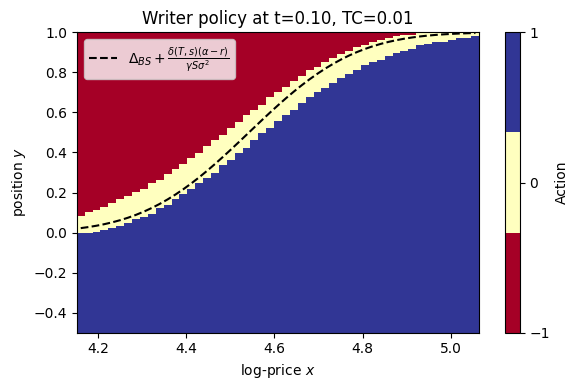

no‐TC price = 10.4538
Avg shares moved per node: 0.008921326422228527
Trading frequency: 0.997434616478389


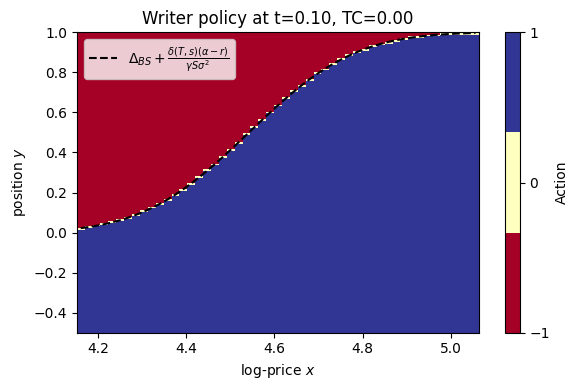

Zero TC price:  10.4538409031234
Sensitivity to Transaction Costs : 57.91%
Black Scholes price: 10.450583572185565
Difference: 0.003257330937834979


In [20]:
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------
cost = 0.01
gamma = 0.5
TC2 = TC_pricer2(opt_param, diff_param, cost_b=cost, cost_s=cost, gamma=gamma)
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------




# 1) run pricer
price, Qs, As, xgrids, ygrid = run_and_track(TC2, N=500, TYPE="writer")
print(f"1%‐TC price = {price:.4f}")

# 2) frequence
dy = ygrid[1] - ygrid[0]
freq = compute_num_shares(As, dy)
print("Avg shares moved per node:", freq)

num_trades = compute_trade_frequency(As)
print("Trading frequency:", num_trades)

#-----------------------------------------------------------------------------------
# 3) pick a t_plot and slice index k
#-----------------------------------------------------------------------------------
t_plot = 0.1
N = 500
k = int(round(t_plot/TC2.T * N))

# 4) compute analytic φ_w
xk = xgrids[k]
S_k, Δ_bs, φ_w = compute_phi_w(xk,
                              K=opt_param.K,
                              r=diff_param.r,
                              mu=diff_param.mu,
                              sig=diff_param.sig,
                              T=TC2.T,
                              t=t_plot,
                              gamma=TC2.gamma)

# 5) plot
plot_policy_and_phi(xk, ygrid, As[k],
                    φ_w,
                    title=f"Writer policy at t={t_plot:.2f}, TC={TC2.cost_b:.2f}")






#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------
gamma = 0.0001
pricer0 = TC_pricer2(opt_param, diff_param, cost_b=0.0, cost_s=0.0, gamma=gamma)
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------



# 1) run pricer
price_no, Qs_no, As_no, xgrids, ygrid = run_and_track(pricer0, N=500, TYPE="writer")
print(f"no‐TC price = {price_no:.4f}")

# 2) frequence
dy = ygrid[1] - ygrid[0]
freq = compute_num_shares(As_no, dy)
print("Avg shares moved per node:", freq)

num_trades = compute_trade_frequency(As_no)
print("Trading frequency:", num_trades)

#-----------------------------------------------------------------------------------
# 3) pick a t_plot and slice index k
#-----------------------------------------------------------------------------------
t_plot = 0.1
N = 500
k = int(round(t_plot/TC2.T * N))

# 4) compute analytic φ_w
xk = xgrids[k]
S_k, Δ_bs, φ_w = compute_phi_w(xk,
                              K=opt_param.K,
                              r=diff_param.r,
                              mu=diff_param.mu,
                              sig=diff_param.sig,
                              T=pricer0.T,
                              t=t_plot,
                              gamma=pricer0.gamma)

# 5) plot
plot_policy_and_phi(xk, ygrid, As_no[k],
                    φ_w,
                    title=f"Writer policy at t={t_plot:.2f}, TC={pricer0.cost_b:.2f}")


bs = BS.closed_formula()

print("Zero TC price: ", price_no)
change = round(((price-price_no)/price_no)*100,2)
print(f"Sensitivity to Transaction Costs : {change}%")
print("Black Scholes price:", bs)
print("Difference:", np.abs(price_no - bs))


# Simulations for one trajectory

#### We obviously start with y=0 in our DP but since we can only move by $\Delta_y$ at each step, for early time steps we don't immediatly join the theoretical optimal holdings, even though it would be optimal without transaction costs.

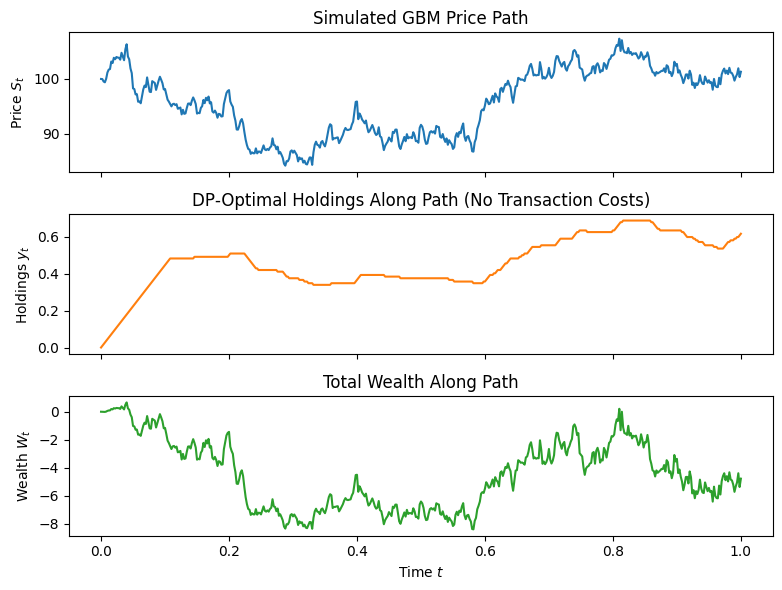

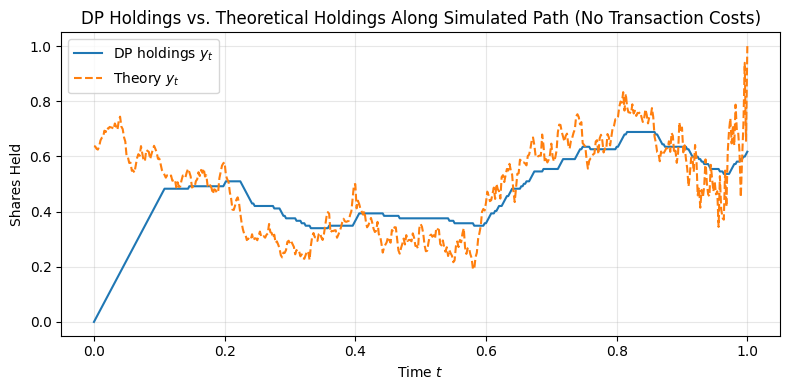

In [ ]:
# -----------------------------------------------------------------------------
# 1) Simulate one trajectory using your existing function & policy:
# -----------------------------------------------------------------------------
t_vec, S_path, y_path, B_path, W_path = simulate_wealth_and_policy(
    pricer0, As, xgrids, ygrid,
    S0=pricer0.S0, T=pricer0.T,
    mu=pricer0.mu, sigma=pricer0.sig, r=pricer0.r,
    cost_b=pricer0.cost_b, cost_s=pricer0.cost_s,
    N=500, B0=0.0, seed=None   # omit seed for a fresh path
)

# -----------------------------------------------------------------------------
# 2) Plot the simulated path: price, holdings, wealth
# -----------------------------------------------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

axs[0].plot(t_vec, S_path, color='C0')
axs[0].set_ylabel('Price $S_t$')
axs[0].set_title('Simulated GBM Price Path')

axs[1].plot(t_vec, y_path, color='C1')
axs[1].set_ylabel('Holdings $y_t$')
axs[1].set_title('DP‐Optimal Holdings Along Path (No Transaction Costs)')

axs[2].plot(t_vec, W_path, color='C2')
axs[2].set_ylabel('Wealth $W_t$')
axs[2].set_xlabel('Time $t$')
axs[2].set_title('Total Wealth Along Path')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3) Compute theoretical φ_w(t,S_t) from eq. (4.31) along the same path
# -----------------------------------------------------------------------------
tau        = TC2.T - t_vec
d1         = (np.log(S_path/opt_param.K) 
              + (TC2.r + 0.5*TC2.sig**2)*tau) \
             / (TC2.sig * np.sqrt(tau))
delta_bs   = norm.cdf(d1)
discount   = np.exp(-TC2.r * tau)
phi_w_path = delta_bs + discount * (TC2.mu - TC2.r) \
             / (TC2.gamma * TC2.sig**2 * S_path)

# -----------------------------------------------------------------------------
# 4) Overlay DP holdings and theoretical φ_w
# -----------------------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(t_vec, y_path,    label='DP holdings $y_t$',        color='C0')
plt.plot(t_vec, phi_w_path,'--', label='Theory $y_t$', color='C1')
plt.xlabel('Time $t$')
plt.ylabel('Shares Held')
plt.title('DP Holdings vs. Theoretical Holdings Along Simulated Path (No Transaction Costs)')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Here we compare various TC, strikes and gamma

In [8]:
from IPython.display import display


tc_list     = [0.0, 0.005, 0.01, 0.02]      # transaction cost levels
strike_list = [5, 10, 15, 20]               # strikes to compare
gamma_list  = [0.5, 0.0001]                 # two γ values
N           = 500

records = []
for gamma in gamma_list:
    for K in strike_list:
        # rebuild Option_param with new strike
        opt = Option_param(
            S0       = opt_param.S0,
            K        = K,
            T        = opt_param.T,
            exercise = opt_param.exercise,
            payoff   = opt_param.payoff
        )
        for tc in tc_list:
            # 1) solve DP
            pr = TC_pricer2(opt, diff_param,
                            cost_b=tc, cost_s=tc, gamma=gamma)
            price, Qs, As, xgrids, ygrid = run_and_track(pr, N=N, TYPE="writer")
            # 2) Black–Scholes benchmark
            bs_price = BS_pricer(opt, diff_param).closed_formula()
            rel_diff = 100*(price - bs_price)/bs_price
            # 3) metrics
            intensity  = compute_num_shares(
                As, ygrid[1] - ygrid[0])
            avg_trades = compute_trade_frequency(As)
            # 4) record
            records.append({
                "Gamma":      gamma,
                "Strike":     K,
                "TC (%)":     tc*100,
                "TC Price":   price,
                "BS Price":   bs_price,
                "RelDiff (%)":rel_diff,
                "Intensity":  intensity,
                "AvgTrades":  avg_trades
            })

df = pd.DataFrame(records)
display(df)


,Gamma,Strike,TC (%),TC Price,BS Price,RelDiff (%),Intensity,AvgTrades
0,0.5000,5,0.0,104.550369,95.243853,9.771251,0.007594,0.849066
1,0.5000,5,0.5,105.154009,95.243853,10.405035,0.007555,0.844681
2,0.5000,5,1.0,105.758275,95.243853,11.039475,0.007542,0.843194
3,0.5000,5,2.0,106.966984,95.243853,12.308543,0.007524,0.841159
4,0.5000,10,0.0,99.794222,90.487706,10.284840,0.007597,0.849339
5,0.5000,10,0.5,100.397862,90.487706,10.951936,0.007552,0.844310
6,0.5000,10,1.0,101.002127,90.487706,11.619724,0.007536,0.842542
7,0.5000,10,2.0,102.210837,90.487706,12.955496,0.007515,0.840156
8,0.5000,15,0.0,95.038075,85.731559,10.855415,0.007599,0.849620
9,0.5000,15,0.5,95.641715,85.731559,11.559519,0.007553,0.844460


<Axes: xlabel='TC (%)', ylabel='RelDiff (%)'>

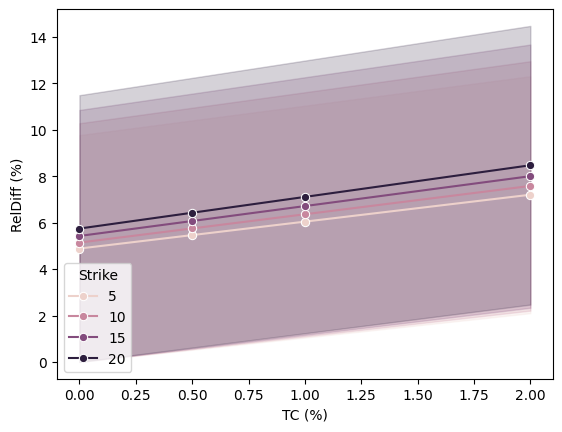

In [9]:
import seaborn as sns
sns.lineplot(data=df, x="TC (%)", y="RelDiff (%)", hue="Strike", marker="o")


# Here we plot the indirect utility function

RMSE between no option and option : 8.308148362110449e-16
RMSE between theoretical value function and no option : 0.0
RMSE between theoretical value function with W-f and option : 0.0036417864607001635


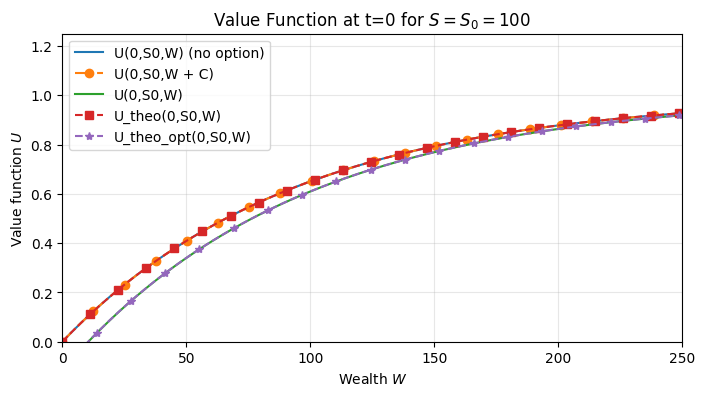

In [67]:
import numpy as np
import matplotlib.pyplot as plt

pricer0.gamma = 0.01

# ─────────────────────────────────────────────────────────────────────────────
# 1) Run your pricer (with track_policy=True)
price = pricer0.price(N=500, TYPE="writer", track_policy=True)

Q_no_list = pricer0.Q_slices['no_opt']
Q_wr_list = pricer0.Q_slices['writer']

# 2) pick out the time-0 arrays and the "y=0" column
#    at t=0 the Q array has shape (1, len(ygrid))
Q0_no = Q_no_list[0]     # <-- shape (1, Ny)
Q0_wr = Q_wr_list[0]     # <-- shape (1, Ny)

# find the index of y==0
med = np.argmin(np.abs(ygrid))

Q0_no_val = Q0_no[0, med]
Q0_wr_val = Q0_wr[0, med]

# 3) build the U(W) curves
δ0 = np.exp(-pricer0.r * pricer0.T)
C  = price

W = np.linspace(0, 250, 200)
U_no       = 1 - np.exp(-pricer0.gamma * W/δ0) * Q0_no_val
U_withfee  = 1 - np.exp(-pricer0.gamma * (W+C)/δ0) * Q0_wr_val
U_withoutfee  = 1 - np.exp(-pricer0.gamma * (W)/δ0) * Q0_wr_val

factor = (pricer0.mu - pricer0.r)**2 / (2 * pricer0.sig**2) * pricer0.T

U_theo = [
    1
    - np.exp(
        -pricer0.gamma
        * w
        / np.exp(-pricer0.r * pricer0.T)
        - factor
      )
    for w in W
]

bs = BS.closed_formula()

U_theo_opt = [
    1
    - np.exp(
        -pricer0.gamma
        * (w-bs)
        / np.exp(-pricer0.r * pricer0.T)
        - factor
      )
    for w in W
]


print(f'RMSE between no option and option : {np.sqrt(np.sum((U_no-U_withfee)**2))}')
print(f'RMSE between theoretical value function and no option : {np.sqrt(np.sum((U_no-U_theo)**2))}')
print(f'RMSE between theoretical value function with W-f and option : {np.sqrt(np.sum((U_withoutfee-U_theo_opt)**2))}')

# 4) plot
plt.figure(figsize=(8,4))
plt.plot(W,         U_no,      label='U(0,S0,W) (no option)',   color='C0')
plt.plot(W,         U_withfee, '-.', label='U(0,S0,W + C)', marker='o', markevery=10,    color='C1')
plt.plot(W,         U_withoutfee, '-', label='U(0,S0,W)',       color='C2')
plt.plot(W,         U_theo, '--', label='U_theo(0,S0,W)', marker='s', markevery=9,    color='C3')
plt.plot(W,         U_theo_opt, '--', label='U_theo_opt(0,S0,W)', marker='*', markevery=11,    color='C4')
plt.xlabel('Wealth $W$')
plt.ylabel('Value function $U$')
plt.title(f'Value Function at t=0 for $S=S_0={pricer0.S0}$')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim((0,1.25))
plt.xlim(0, W.max())
plt.show()


### For high gammas, since the utility price differs from the Black-Scholes (without transaction costs), subtracting the BS price to the wealth of the theoretical value function, doesn't coincide with the one observed. 
### However, for low gammas, the two correspond perfectly

We expect that if the transaction costs are **zero**, and the risk aversion coefficient $\gamma \to 0$ (i.e. the investor becomes risk neutral), the price should **converge** to the **Black-Scholes price**

In [ ]:
tc = TC2.price(N=1000)
bs = BS.closed_formula()

print("Zero TC price: ", tc)
print("Black Scholes price:", bs)
print("Difference:", np.abs(tc - bs))

Zero TC price:  14.978038262434346
Black Scholes price: 14.9757907783113
Difference: 0.002247484123046206


#### Wait a second!!! WE CAN DO BETTER!

##### Let us analyze the the writer and buyer prices, for different initial stock values.

In [37]:
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------
cost = 0.1
gamma = 0.0001
TC2 = TC_pricer2(opt_param, diff_param, cost_b=cost, cost_s=cost, gamma=gamma)
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------

S = list(range(10, 22))
price_0 = []
price_w = []
price_b = []

for s in S:
    TC2.S0 = s
    TC2.cost_b = 0
    TC2.cost_s = 0
    price_0.append(TC2.price(N=400))  # zero costs
    TC2.cost_b = 0.05
    TC2.cost_s = 0.05
    price_w.append(TC2.price(N=400, TYPE="writer"))
    price_b.append(TC2.price(N=400, TYPE="buyer"))
TC2.cost_b = 0
TC2.cost_s = 0  # set to 0 for future computations

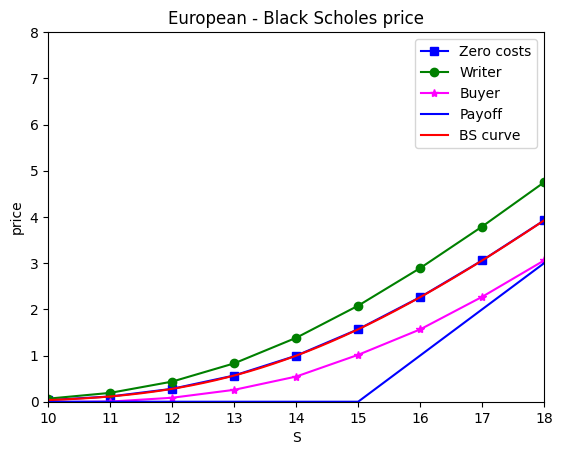

In [38]:
plt.plot(S, price_0, color="blue", marker="s", label="Zero costs")
plt.plot(S, price_w, color="green", marker="o", label="Writer")
plt.plot(S, price_b, color="magenta", marker="*", label="Buyer")
BS.plot(axis=[10, 18, 0, 8])  # plot of the Black Scholes line

# Analysis of the Writer-Buyer difference

## Sensitivity to Transaction Costs

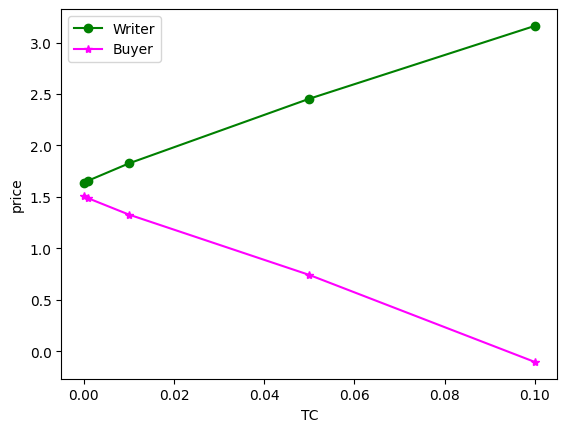

In [46]:
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------
cost = 0.01
gamma = 0.5
TC2 = TC_pricer2(opt_param, diff_param, cost_b=cost, cost_s=cost, gamma=gamma)
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------

price_tc1 = []
price_tc2 = []
tcs = [0.0, 0.001, 0.01, 0.05, 0.1]
TC2.gamma = 0.5  # high value of risk aversion


for tc in tcs:
    TC2.cost_b = tc
    TC2.cost_s = tc
    price_tc1.append(TC2.price(N=400, TYPE="writer"))
    price_tc2.append(TC2.price(N=400, TYPE="buyer"))

plt.plot(tcs, price_tc1, color="green", marker="o", label="Writer")
plt.plot(tcs, price_tc2, color="magenta", marker="*", label="Buyer")
plt.xlabel("TC")
plt.ylabel("price")
plt.legend()
plt.show()

<a id='sec5.2'></a>
### Is the risk aversion important?

The coefficient $\gamma$ measure the risk aversion of the investor. We can see how the option price is affected by this coefficient:

## Sensitivity to Risk Aversion (gamma)

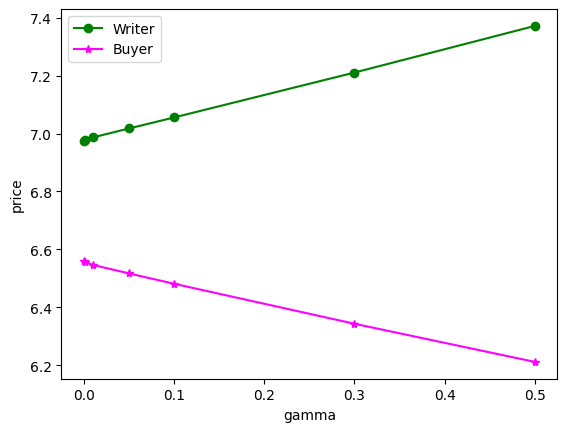

In [ ]:
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------
cost = 0.01
gamma = 0.5
TC2 = TC_pricer2(opt_param, diff_param, cost_b=cost, cost_s=cost, gamma=gamma)
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------

price_ww = []
price_bb = []
gammas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.3, 0.5]
TC2.cost_b = 0.01
TC2.cost_s = 0.01

for gamma in gammas:
    TC2.gamma = gamma
    price_ww.append(TC2.price(N=400, TYPE="writer"))
    price_bb.append(TC2.price(N=400, TYPE="buyer"))

plt.plot(gammas, price_ww, color="green", marker="o", label="Writer")
plt.plot(gammas, price_bb, color="magenta", marker="*", label="Buyer")
plt.xlabel("gamma")
plt.ylabel("price")
plt.legend()
plt.show()

So far we have found that:

- The option pricing is an increasing function of the risk aversion coefficient for the writer, and a decreasing function for the buyer.

- The option pricing is an increasing function of the transaction costs for the writer, and a decreasing function for the buyer.

<a id='sec5.3'></a>
### Is the drift important? 

As we know from the "classical" no-arbitrage martingale pricing theory, the option price does not depend on the stock expected value. 

However, this model is a utility based model i.e. a model that does not consider a risk neutral investor. 

We can see that in this model the option price depends on the drift. 

If we consider a high risk aversion coefficient, the option price is not very sensitive to the drift. If instead we choose a small value of $\gamma$, i.e. the investor is risk neutral, the drift plays the role of the risk neutral expected return $r$ and therefore changing $\mu$, is like changing $r$.

Following Hodges-Neuberger [2], in the practical computations **it is better to set $\mu=r$.**

## Sensitivity to mu

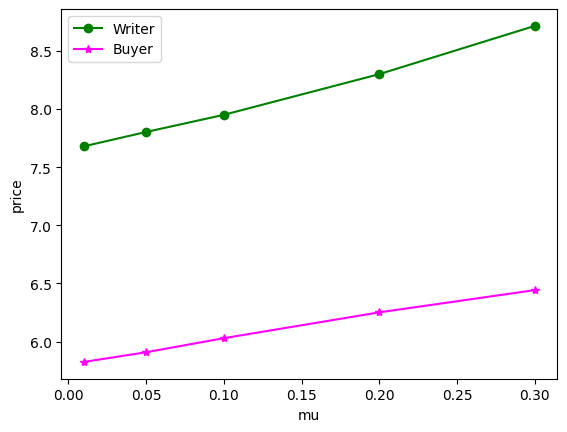

In [ ]:
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------
cost = 0.01
gamma = 0.5
TC2 = TC_pricer2(opt_param, diff_param, cost_b=cost, cost_s=cost, gamma=gamma)
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------

price_mu1 = []
price_mu2 = []
mus = [0.01, 0.05, 0.1, 0.2, 0.3]
TC2.gamma = 1  # high value of risk aversion
TC2.cost_b = 0.01
TC2.cost_s = 0.01

for mu in mus:
    TC2.mu = mu
    price_mu1.append(TC2.price(N=400, TYPE="writer"))
    price_mu2.append(TC2.price(N=400, TYPE="buyer"))

plt.plot(mus, price_mu1, color="green", marker="o", label="Writer")
plt.plot(mus, price_mu2, color="magenta", marker="*", label="Buyer")
plt.xlabel("mu")
plt.ylabel("price")
plt.legend()
plt.show()

## Snesititvity to sigma

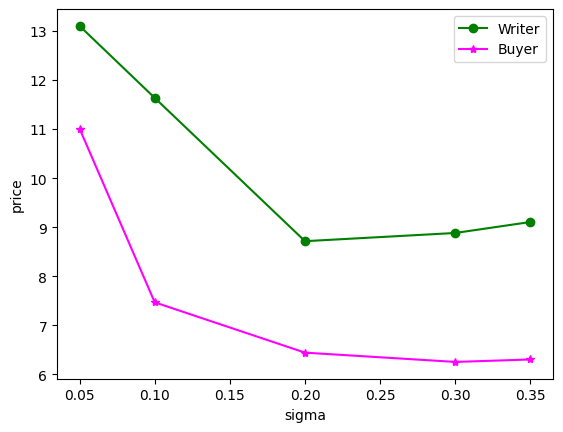

In [ ]:
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------
cost = 0.01
gamma = 0.5
TC2 = TC_pricer2(opt_param, diff_param, cost_b=cost, cost_s=cost, gamma=gamma)
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------

price_sig1 = []
price_sig2 = []
sigmas = [0.05, 0.1, 0.2, 0.3, 0.35]
TC2.gamma = 1  # high value of risk aversion
TC2.cost_b = 0.01
TC2.cost_s = 0.01

for sig in sigmas:
    TC2.sig = sig
    price_sig1.append(TC2.price(N=400, TYPE="writer"))
    price_sig2.append(TC2.price(N=400, TYPE="buyer"))

plt.plot(sigmas, price_sig1, color="green", marker="o", label="Writer")
plt.plot(sigmas, price_sig2, color="magenta", marker="*", label="Buyer")
plt.xlabel("sigma")
plt.ylabel("price")
plt.legend()
plt.show()

<a id='sec5.1'></a>
### Time complexity

If we set the "Time" argument to True, the method also returns the execution time.
Let us verify that the algorithm has time complexity of order $\mathcal{O}(N^4)$

The following operation will be very time consuming. In case you are in a hurry, reduce the NUM.

In [39]:
NUM = 5
price_table = pd.DataFrame(columns=["N", "Price", "Time"])
for j, n in enumerate([50 * 2**i for i in range(NUM)]):
    price_table.loc[j] = [n] + list(TC2.price(n, Time=True))
display(price_table)

,N,Price,Time
0,50.0,6.766803,0.026982
1,100.0,6.766202,0.045873
2,200.0,6.766252,0.185319
3,400.0,6.766623,1.087834
4,800.0,6.766552,10.033491


Using the computational times we can estimate the exponent $\alpha$ of the polinomial growth $\mathcal{O}(N^\alpha)$. 

For higher values of N, the exponent converges to the expected value of $\alpha = 4$.

Here we are quite close.

In [40]:
print("The exponent is: ", np.log2(price_table["Time"][4] / price_table["Time"][3]))

The exponent is:  3.205293471570579


### Other references

[1] Cantarutti, N., Guerra, J., Guerra, M., and Grossinho, M. (2019). Option pricing in exponential Lévy models with transaction costs. [*ArXiv*](https://arxiv.org/abs/1611.00389). 

[2] Hodges, S. D. and Neuberger, A. (1989). Optimal replication of contingent claims under transaction costs. The Review of Future Markets, 8(2):222–239.